# Data Description

## TUAB
----
* labels legend:
	1. label 0 = abnormal
	2. label 1 = normal
* Channel set: A1, A2, C3, C4, CZ, F3, F4, F7, F8, FP1, FP2, FZ, O1, O2, P3, P4, PZ, T3, T4, T5, T6  
* Sample frequency: 250 Hz


## TUAR
-----
* labels legend:
	1. label 0 = artifact
	2. label 1 = clean
* Channel set: A1, A2, C3, C4, CZ, F3, F4, F7, F8, FP1, FP2, FZ, O1, O2, P3, P4, PZ, T1, T2, T3, T4, T5, T6
* Sample frequency: 250 Hz

* Channels to be removed before merging: T1, T2

In [2]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Feature Selection and Pre-processing Imports
from sklearn.preprocessing import StandardScaler

#Model Selection  and Classifier Imports
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV, LeaveOneOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

#Metrics Imports
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, RocCurveDisplay
from sklearn.metrics import matthews_corrcoef, classification_report, roc_curve, auc, recall_score, f1_score, roc_auc_score

#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import pairplot as pplot

#Data Augmentation Library
from imblearn.over_sampling import SMOTE

## Helper Function to load the data

In [3]:
def read_from_h5(path):
    f = h5py.File(path, 'r')
    data = np.array(f['dataset'])
    label = np.array(f['label'])
    ID = np.array([i.decode('utf_8') for i in np.array(f['ID'])])
    
    return data, label, ID


data_ar, label_ar, ID_ar = read_from_h5('TUAR.hdf5')  # artifact(0) + clean(1) signal
data_ab, label_ab, ID_ab = read_from_h5('TUAB.hdf5')  # abnormal(0) + normal(1) signal


## Making sense of Data

* data - N-Dimensional numpy array with shape (200,500,23/21) , last dimension represents the no. of channels.
* label - 200 labels for the samples
* ID - ID of the samples

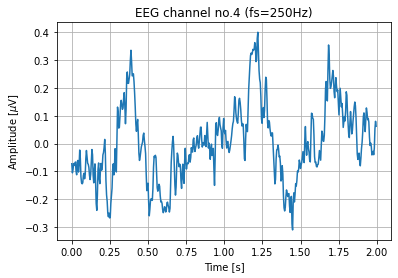

In [7]:
fig = plt.figure
time = np.arange(0,2,1/250)
plt.plot(time, data_ar[0,:,4])
plt.tight_layout
plt.ylabel('Amplitude [$\mu$V]')
plt.title('EEG channel no.4 (fs=250Hz)')
plt.xlabel('Time [s]')
plt.grid(True)
plt.savefig('Sample_eeg_signal', dpi = 400)
plt.show()


In [4]:
# Shape of the two datasets and Removing uncommon channels from TUAR dataset

print('Shape of the two datasets are TUAB: {} , TUAR: {}'.format(data_ab.shape , data_ar.shape))

data_ar = np.delete(data_ar,[17,18],axis = 2)
print('Shape of the two datasets are TUAB: {} , TUAR: {}'.format(data_ab.shape , data_ar.shape))

Shape of the two datasets are TUAB: (200, 500, 21) , TUAR: (200, 500, 23)
Shape of the two datasets are TUAB: (200, 500, 21) , TUAR: (200, 500, 21)


In [5]:
def combineDatasets (dataset1, dataset2, newshape):
    d1 = dataset1.copy()
    d2 = dataset2.copy()
    
    data = np.vstack((d1,d2))
    print(data.shape)
    
    # For each sample/person combine the data from the 21 channels into a single vector
    data = data.reshape(newshape) 
    print(data.shape)
    
    return data

newshape = (400,500*21)
combinedData = combineDatasets(data_ab, data_ar, newshape)

(400, 500, 21)
(400, 10500)


In [6]:
# clean + normal  = 1, abnormal = 2, artifact = 3

def combineLabels(label_ab, label_ar):
    labeld1 = label_ab.copy() # abnormal + normal
    labeld2 = label_ar.copy() # artifact + clean
    
    labeld1[labeld1 == 0] = 2 # abnormal = 2
    labeld2[labeld2 == 0] = 3 # artifact = 3
    
    combinedLabels = np.concatenate((labeld1, labeld2))
    
    return combinedLabels

newLabels = combineLabels(label_ab,label_ar)


# permute the data
np.random.seed(12345)
idx = np.random.permutation(400)

combinedData = combinedData[idx]
newLabels = newLabels[idx]

# print(newLabels)

## Pipeline 1 Stage 1



In [7]:
training_size = int(0.70 * (newLabels.size))

X_train = combinedData[: training_size]
y_train = newLabels[: training_size]

X_test = combinedData[training_size:]
y_test = newLabels[training_size:]

print(np.unique(y_train, return_counts=True))

(array([1, 2, 3]), array([145,  70,  65]))


In [8]:
# clean + normal  = 1, abnormal = 2, artifact = 3 -> Original relabeling
# (clean + normal + abnormal) 0  vs (Artifact) 1

X_train_pip1_stage1 = X_train.copy()
y_train_pip1_stage1 = y_train.copy()

y_train_pip1_stage1[(y_train_pip1_stage1 != 3)] = 0
y_train_pip1_stage1[y_train_pip1_stage1 == 3] = 1

X_test_pip1_stage1 = X_test.copy()
y_test_pip1_stage1 = y_test.copy()

y_test_pip1_stage1[(y_test_pip1_stage1 != 3)] = 0
y_test_pip1_stage1[y_test_pip1_stage1 == 3] = 1

print(np.unique(y_train_pip1_stage1,return_counts=True))

(array([0, 1]), array([215,  65]))


In [10]:
def rfmodel1(X_train, y_train, X_test, y_test):
    clf = RandomForestClassifier(n_estimators=10,max_depth=5, random_state=42)
    
    clf.fit(X_train,y_train)
    
    training_prediction = clf.predict(X_train)
    test_prediction = clf.predict(X_test)
    
    train_score = clf.score(X_train,y_train)
    test_score = clf.score(X_test,y_test)
    
    print('Training Score: ',train_score, '\nTest Score: ',test_score)
    
    return training_prediction, test_prediction, train_score, test_score

s1train_prediction, s1test_prediction, s1train_score, s1test_score = rfmodel1(X_train_pip1_stage1, y_train_pip1_stage1, X_test_pip1_stage1, y_test_pip1_stage1)


Training Score:  0.9035714285714286 
Test Score:  0.6916666666666667


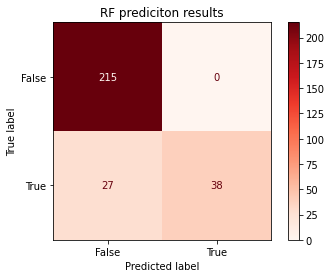

Model ROC-AUC: 0.7923076923076924
Accuracy score : 0.9035714285714286


In [11]:
# Confusion Matrix of the predictions

def confusionMatrix(actual, predicted):
    cm = metrics.confusion_matrix(actual,predicted)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix = cm,
        display_labels = [False, True],
    )
    cm_display = cm_display.plot(cmap=plt.cm.Reds,values_format='g')
    plt.grid(False)
    plt.title('RF prediciton results')
    plt.show()
    print ('Model ROC-AUC:',roc_auc_score(actual,predicted))
    print('Accuracy score :',accuracy_score(actual,predicted))

confusionMatrix(y_train_pip1_stage1, s1train_prediction)


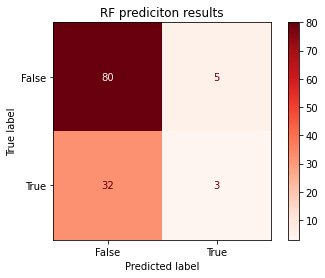

Model ROC-AUC: 0.5134453781512605
Accuracy score : 0.6916666666666667


In [12]:
confusionMatrix(y_test_pip1_stage1, s1test_prediction)

In [13]:
# Pipeline 1 Stage 2
# (clean + normal + abnormal)  --> clean + normal (Healthy) 1 vs Abnormal (Pathological) 0


idx_train = np.where((s1train_prediction == y_train_pip1_stage1) & (y_train_pip1_stage1 == 0))[0]
idx_test = np.where(y_test != 3)[0]

X_train_pip1_stage2 = X_train[idx_train]
y_train_pip1_stage2 = y_train[idx_train]

# y_train_pip1_stage2[y_train_pip1_stage2 != 2] = 0 #Abnormal 
y_train_pip1_stage2[y_train_pip1_stage2 == 2] = 0 #Abnormal 

X_test_pip1_stage2 = X_test[idx_test]
y_test_pip1_stage2 = y_test[idx_test]

# y_test_pip1_stage2[y_test_pip1_stage2 != 2] = 0 #Abnormal 
y_test_pip1_stage2[y_test_pip1_stage2 == 2] = 0 #Abnormal 

np.unique(y_train_pip1_stage2, return_counts=True)

(array([0, 1]), array([ 70, 145]))

In [14]:
s2train_prediction, s2test_prediction, s2train_score, s2test_score = rfmodel1(X_train_pip1_stage2, y_train_pip1_stage2, X_test_pip1_stage2, y_test_pip1_stage2)


Training Score:  0.9348837209302325 
Test Score:  0.7176470588235294


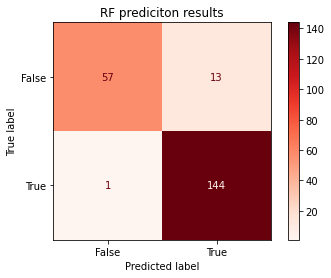

Model ROC-AUC: 0.9036945812807882
Accuracy score : 0.9348837209302325


In [15]:
confusionMatrix(y_train_pip1_stage2, s2train_prediction)

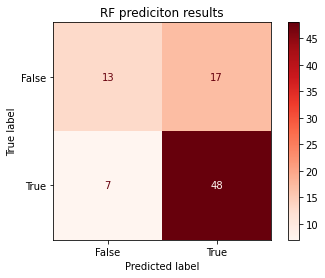

Model ROC-AUC: 0.6530303030303031
Accuracy score : 0.7176470588235294


In [16]:
confusionMatrix(y_test_pip1_stage2, s2test_prediction)

## Pipeline 2

In [17]:
# clean + normal  = 1, abnormal = 2, artifact = 3 -> Original relabeling
# (clean + normal) 1  vs (abnormal + Artifact) 0

X_train_pip2_stage1 = X_train.copy()
y_train_pip2_stage1 = y_train.copy()

y_train_pip2_stage1[(y_train_pip2_stage1 != 1)] = 0
# y_train_pip1_stage1[y_train_pip1_stage1 == 3] = 1

X_test_pip2_stage1 = X_test.copy()
y_test_pip2_stage1 = y_test.copy()

y_test_pip2_stage1[(y_test_pip2_stage1 != 1)] = 0
# y_test_pip1_stage1[y_test_pip1_stage1 == 3] = 1

print(np.unique(y_train_pip2_stage1,return_counts=True))

(array([0, 1]), array([135, 145]))


In [18]:
p2s1train_prediction, p2s1test_prediction, p2s1train_score, p2s1test_score = rfmodel1(X_train_pip2_stage1, y_train_pip2_stage1, X_test_pip2_stage1, y_test_pip2_stage1)


Training Score:  0.9142857142857143 
Test Score:  0.5666666666666667


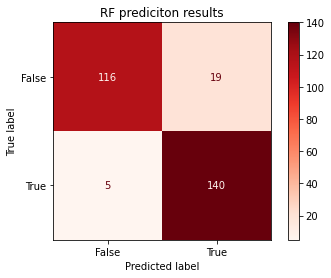

Model ROC-AUC: 0.9123882503192849
Accuracy score : 0.9142857142857143


In [19]:
confusionMatrix(y_train_pip2_stage1, p2s1train_prediction)

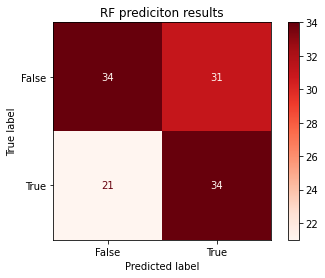

Model ROC-AUC: 0.5706293706293706
Accuracy score : 0.5666666666666667


In [20]:
confusionMatrix(y_test_pip2_stage1, p2s1test_prediction)

In [21]:
# Stage 2 --> (abnormal vs Artifact) or (Pathological vs Artifact)

idx_train = np.where((p2s1train_prediction == y_train_pip2_stage1) & (y_train_pip2_stage1 == 0))[0]
idx_test = np.where(y_test != 1)[0]

X_train_pip2_stage2 = X_train[idx_train]
y_train_pip2_stage2 = y_train[idx_train]

y_train_pip2_stage2[y_train_pip2_stage2 != 2] = 1 #Artifact 
y_train_pip2_stage2[y_train_pip2_stage2 == 2] = 0 #Abnormal 

X_test_pip2_stage2 = X_test[idx_test]
y_test_pip2_stage2 = y_test[idx_test]

y_test_pip2_stage2[y_test_pip2_stage2 != 2] = 1 #Artifact
y_test_pip2_stage2[y_test_pip2_stage2 == 2] = 0 #Abnormal 

np.unique(y_train_pip2_stage2, return_counts=True)

(array([0, 1]), array([63, 53]))

In [22]:
p2s2train_prediction, p2s2test_prediction, p2s2train_score, p2s2test_score = rfmodel1(X_train_pip2_stage2, y_train_pip2_stage2, X_test_pip2_stage2, y_test_pip2_stage2)


Training Score:  0.9913793103448276 
Test Score:  0.6923076923076923


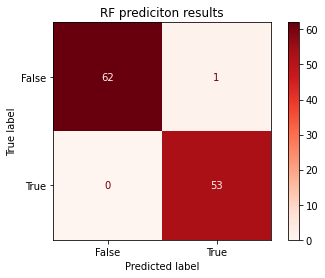

Model ROC-AUC: 0.9920634920634921
Accuracy score : 0.9913793103448276


In [23]:
confusionMatrix(y_train_pip2_stage2, p2s2train_prediction)

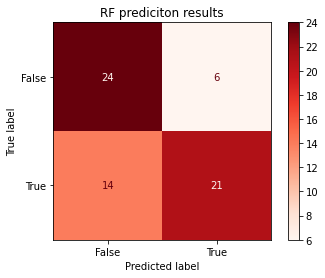

Model ROC-AUC: 0.7000000000000002
Accuracy score : 0.6923076923076923


In [24]:
confusionMatrix(y_test_pip2_stage2, p2s2test_prediction)